In [1]:
import sys
import os
import time

import ast
import csv
import math
import random
import copy
import itertools
import numpy as np
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import GRB


import numpy as np
from itertools import combinations
from math import comb

from joblib import Parallel, delayed

## Todas as funções criadas

In [2]:
def read_input(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
    
    n, m, p = map(int, data[0].split())
    edges = []
    
    for i in range(m):
        u, v, cost = map(int, data[i + 1].split())
        edges.append((u - 1, v - 1, cost))  # Convertendo para 0-index
    
    return n, edges, p

def floyd_warshall(n, edges):
    # Inicializando a matriz de custos com infinito
    inf = sys.maxsize
    cost = [[inf] * n for _ in range(n)]
    
    # Preenchendo a diagonal com 0
    for i in range(n):
        cost[i][i] = 0
    
    # Preenchendo a matriz de custos com os valores do arquivo
    for u, v, c in edges:
        cost[u][v] = c
        cost[v][u] = c
    
    # Algoritmo de Floyd-Warshall
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if cost[i][j] > cost[i][k] + cost[k][j]:
                    cost[i][j] = cost[i][k] + cost[k][j]
    
    return cost


# Função para ler todas as distâncias do arquivo txt
def read_input_distances(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    distancias = []
    d = []
    for line in lines:
        line = line.strip()
        if line.startswith("Instance"):
            if d:
                distancias.append(d)
                d = []
        elif line:
            row = list(map(float, line.split()))
            d.append(row)
    if d:  # adiciona a última
        distancias.append(d)

    return distancias

# Estratégia gulosa para gerar solução inicial
def metodo_guloso(n, P, d):
    # Inicialmente, nenhum fornecedor está aberto
    opened = []
    remaining = list(range(n))
    
    # Inicializar vetor de alocação com distâncias infinitas
    customer_assign_costs = [float('inf')] * n
    
    for _ in range(P):
        best_facility = None
        best_improvement = float('inf')
        
        for j in remaining:
            total_cost = 0
            for i in range(n):
                # Para cada cliente, considera a melhor distância se j for adicionado
                total_cost += min(customer_assign_costs[i], d[i][j])
            if total_cost < best_improvement:
                best_improvement = total_cost
                best_facility = j
        
        opened.append(best_facility)
        remaining.remove(best_facility)
        # Atualiza os custos de alocação com o novo fornecedor
        for i in range(n):
            customer_assign_costs[i] = min(customer_assign_costs[i], d[i][best_facility])

    s0 = [1 if j in opened else 0 for j in range(n)]
    return s0
    
def atribuir_clientes(s):
    abertas = [j for j, val in enumerate(s) if val == 1]
    atribuicao = []
    n_clientes = len(d)
    for i in range(n_clientes):
        j_best = min(abertas, key=lambda j: d[i][j])
        atribuicao.append(j_best)
    return atribuicao


# Vizinhança Swap: troca entre postos aberto e fechado (swap entre 1 e 0)
def vizinhanca_v1(y_):
    vizinhos = []
    abertos = [i for i, val in enumerate(y_) if val == 1]
    fechados = [i for i, val in enumerate(y_) if val == 0]
    for i in abertos:
        for j in fechados:
            novo = y_.copy()
            novo[i], novo[j] = 0, 1
            vizinhos.append(novo)
    return vizinhos

# Vizinhança olha posições antecessora e sucessora da solução para possível troca
def vizinhanca_v3(y_):
    vizinhos = []
    n = len(y_)
    
    for i in range(n):
        # Tenta trocar com a posição anterior
        if i > 0 and y_[i] != y_[i - 1]:
            novo = y_.copy()
            novo[i], novo[i - 1] = novo[i - 1], novo[i]
            vizinhos.append(novo)
        # Se não puder trocar com anterior, tenta sucessor
        elif i < n - 1 and y_[i] != y_[i + 1]:
            novo = y_.copy()
            novo[i], novo[i + 1] = novo[i + 1], novo[i]
            vizinhos.append(novo)
        # Caso contrário, não adiciona vizinho

    return vizinhos

# vizinhanca escolhe aleatoriaente um posto fechado e faz uma troca com o posto aberto
def vizinhanca_v7(y_):
    vizinhos = []
    abertos = [i for i, val in enumerate(y_) if val == 1]
    fechados = [i for i, val in enumerate(y_) if val == 0]

    for i in abertos:
        if not fechados:
            break  # não há para onde trocar
        j = random.choice(fechados)
        novo = y_.copy()
        novo[i], novo[j] = 0, 1
        vizinhos.append(novo)
        fechados.remove(j)  # evita usar o mesmo 0 novamente (opcional)

    return vizinhos

# vizinhanca troca o primeiro posto aberto pelos len(y_)/sum(y_) ultimos postos fechados
def vizinhanca_v9(y_):
    vizinhos = []
    primeiro_aberto = next((i for i, val in enumerate(y_) if val == 1), None)
    
    if primeiro_aberto is None:
        return []  # Não há postos abertos para trocar

    for j in reversed(range(len(y_))):
        if y_[j] == 0:
            novo = y_.copy()
            novo[primeiro_aberto] = 0
            novo[j] = 1
            vizinhos.append(novo)

    return vizinhos

# vizinhaça gera vizinhos trocando um posto aberto por um fechado que reduza o custo total
def vizinhanca_v11(y_):
    vizinhos = []
    abertos = [i for i, val in enumerate(y_) if val == 1]
    fechados = [i for i, val in enumerate(y_) if val == 0]
    P = sum(y_)
    n_clientes = len(d)

    # custo atual
    dist_clientes = [min(d[c][j] for j in abertos) for c in range(n_clientes)]
    custo_atual = sum(dist_clientes)

    for i in abertos:
        for j in fechados:
            # nova lista de abertos
            abertos_novo = [x for x in abertos if x != i] + [j]

            # garantir que continua com P postos abertos
            if len(abertos_novo) != P:
                continue

            # atribuição de clientes
            atribuicao = []
            dist_clientes_novo = []
            for c in range(n_clientes):
                # escolhe o posto aberto mais próximo
                posto_atribuido = min(abertos_novo, key=lambda k: d[c][k])
                atribuicao.append(posto_atribuido)
                dist_clientes_novo.append(d[c][posto_atribuido])

            custo_novo = sum(dist_clientes_novo)

            # só adiciona se melhorar
            if custo_novo < custo_atual:
                novo = y_.copy()
                novo[i], novo[j] = 0, 1
                vizinhos.append(novo)

    return vizinhos


def vizinhanca_v14(y_):
    k = 2  # número de postos que trocam estado
    vizinhos = []
    abertos = [i for i, val in enumerate(y_) if val == 1]
    fechados = [i for i, val in enumerate(y_) if val == 0]

    # se não houver pares suficientes, não gera nada
    if len(abertos) < k or len(fechados) < k:
        return vizinhos

    total_combinacoes = math.comb(len(abertos), k) * math.comb(len(fechados), k)
    limite = 1000000  # limite máximo de combinações

    # print("Total de combinações", total_combinacoes)

    if total_combinacoes < limite:
        # print("Entrou 1")
        comb_abertos = list(itertools.combinations(abertos, k))
        comb_fechados = list(itertools.combinations(fechados, k))

        for a in comb_abertos:
            for f in comb_fechados:
                novo = y_.copy()
                for i in a:
                    novo[i] = 0
                for j in f:
                    novo[j] = 1
                vizinhos.append(novo)
        return vizinhos

    else:
        # print("Entrou 2")

        comb_abertos = list(itertools.combinations(abertos, k))
        comb_fechados = list(itertools.combinations(fechados, k))

        # sorteio direto de até 'limite' pares aleatórios
        for _ in range(min(limite, total_combinacoes)):
            a = random.choice(comb_abertos)
            f = random.choice(comb_fechados)

            novo = y_.copy()
            for i in a:
                novo[i] = 0
            for j in f:
                novo[j] = 1
            vizinhos.append(novo)

        return vizinhos

# f.o. vetorizada
def f(s, d):
    abertas = np.where(np.array(s) == 1)[0]
    if len(abertas) == 0:
        return np.inf
    sub = d[:, abertas]
    return np.sum(np.min(sub, axis=1))

# VND otimizado sem paralelização
def VND(s0, vizinhancas, d, M, N, P):
    tempo_max = 3600
    tempo_limite_vizinhanca = 900

    s = s0.copy()
    f_s = f(s, d)
    print(f"Valor da função objetivo com a Solução Inicial: {f_s:.2f}")

    k = 0
    num_solucoes = 0
    postos = []
    inicio = time.time()

    while k < len(vizinhancas) and (time.time() - inicio) < tempo_max:
        start_time = time.time()
        vizinhos = vizinhancas[k](s)

        # remove duplicatas
        vistos = set()
        vizinhos_unicos = []
        for v in vizinhos:
            chave = tuple(v)
            if chave not in vistos:
                vistos.add(chave)
                vizinhos_unicos.append(v)
        vizinhos = vizinhos_unicos

        print(f"Tamanho da vizinhança {k}: {len(vizinhos)}")

        # busca o melhor vizinho
        melhoria_encontrada = False
        for v in vizinhos:
            if time.time() - start_time > tempo_limite_vizinhanca:
                print(f"Tempo excedido na vizinhança {k}")
                break

            f_v = f(v, d)

            if f_v < f_s:
                s = v
                f_s = f_v
                num_solucoes += 1
                postos_abertos = [j for j in range(N) if s[j] == 1]
                postos.append(postos_abertos)
                #print(f"Melhoria encontrada na vizinhança {k}, novo custo: {f_s:.2f}")
                k = 0
                melhoria_encontrada = True
                break

        if not melhoria_encontrada:
            k += 1

    print('Número de soluções novas encontradas:', num_solucoes)
    return s, f_s

In [3]:
base_directory = 'Base de Dados/OR-Library'
distancias = read_input_distances("distancias_or_library.txt")
solucoes = []

for i in range(39, 40):
    filename = f'{base_directory}/pmed{i+1}.txt'
    if os.path.exists(filename):
        n, arestas, P = read_input(filename)
    else:
        print(f'File {filename} does not exist.')

    #d = distancias[i] d[i][j]
    d = np.array(distancias[i]) #d[i,j]
    
    M = N = n

    # ESTRATÉGIA ALEATÓRIA
    # posicoes = random.sample(range(N), P) 
    # s0 = [1 if j in posicoes else 0 for j in range(N)]

    # ESTRATÉGIA GULOSA
    start_time = time.time()
    s0 = metodo_guloso(n, P, d)
    # print(f"Tempo de execução Método Guloso: {time.time() - start_time:.2f} segundos")
    
    fornecedor_inicial = [j for j in range(N) if s0[j] > 0.5]
    print("Fornecedores inicial:", fornecedor_inicial)

    # vizinhancas = [vizinhanca_v9, vizinhanca_v7, vizinhanca_v3, vizinhanca_v1]
    vizinhancas = [vizinhanca_v9, vizinhanca_v3, vizinhanca_v1]

    
    start_time = time.time()
    melhor_s, melhor_f = VND(s0, vizinhancas, d, M, N, P)
    execution_time = time.time() - start_time

    solucoes.append({
        'Custo': melhor_f,
        'Execution Time': execution_time
    })

    print(f"Tempo de Execução do VND: {execution_time:.2f} segundos")
    print(f"Instance {i+1}: Custo mínimo total: {melhor_f:.1f}")
    fornecedores_abertos = [j for j in range(N) if melhor_s[j] > 0.5]
    print("Fornecedores abertos:", fornecedores_abertos)
    print("\n")

Fornecedores inicial: [8, 15, 40, 50, 53, 62, 89, 103, 107, 114, 120, 123, 139, 140, 148, 152, 177, 180, 224, 257, 262, 270, 282, 299, 301, 305, 307, 314, 319, 336, 337, 348, 371, 374, 383, 386, 392, 396, 403, 405, 431, 433, 440, 480, 489, 490, 497, 500, 506, 515, 520, 528, 536, 544, 550, 552, 557, 565, 566, 575, 577, 613, 617, 621, 629, 638, 642, 647, 652, 675, 679, 709, 730, 738, 749, 758, 780, 802, 803, 805, 842, 844, 849, 852, 865, 866, 870, 877, 882, 886]
Valor da função objetivo com a Solução Inicial: 5190.00
Tamanho da vizinhança 0: 810
Tamanho da vizinhança 0: 810
Tamanho da vizinhança 1: 166
Tamanho da vizinhança 0: 810
Tamanho da vizinhança 1: 168
Tamanho da vizinhança 2: 72900
Tamanho da vizinhança 0: 810
Tamanho da vizinhança 1: 166
Tamanho da vizinhança 2: 72900
Tamanho da vizinhança 0: 810
Tamanho da vizinhança 1: 166
Tamanho da vizinhança 2: 72900
Tamanho da vizinhança 0: 810
Tamanho da vizinhança 1: 164
Tamanho da vizinhança 2: 72900
Tamanho da vizinhança 0: 810
Tamanho

In [ ]:
solucoes

In [4]:
gurobi = [0.46, 0.81, 0.84, 0.36, 0.31, 8.07, 2.27, 1.91, 1.92, 1.82, 12.09, 8.75, 4.11, 4.18, 3.22, 72.41, 43.78, 9.88, 7.90, 6.65, 22.70, 314.60, 15.98, 13.96, 12.00, 266.24, 61.63, 24.39, 22.08, 20.94, 116.96, 89.77, 39.69, 32.26, 385.11, 2644.71, 56.35, 834.09, 495.45, 79.01]

vnd = [0.05, 0.16, 0.57, 0.38, 0.75, 0.58, 0.50, 0.88, 6.29, 8.00, 0.46, 0.89, 12.44, 22.93, 28.26, 0.81, 1.61, 17.66, 81.66, 207.74, 0.59, 1.82, 51.74, 181.93, 540.95, 2.81, 5.47, 159.81, 745.57, 1050.18, 0.89, 7.11, 551.89, 1790.78, 1.53, 8.35, 1060.44, 3.87, 14.11, 932.37]



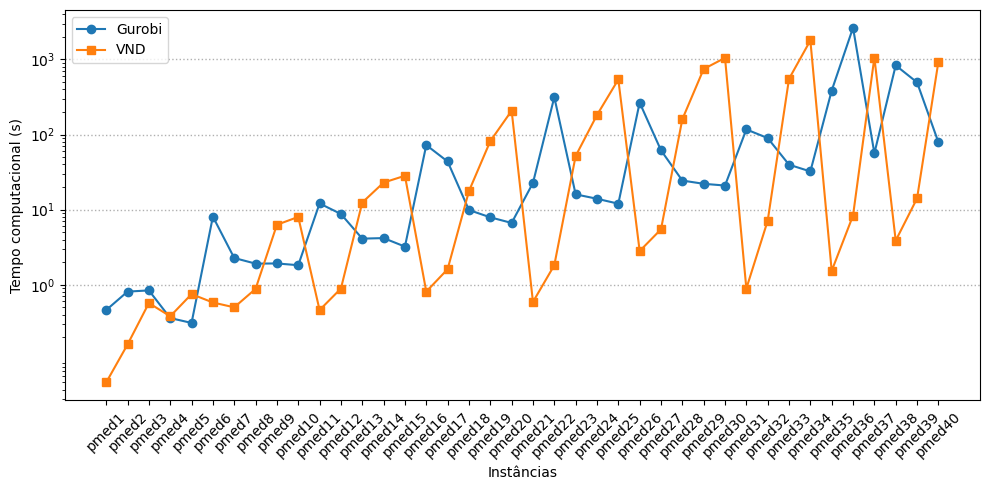

In [5]:
instances = [f"pmed{i}" for i in range(1, 41)]

plt.figure(figsize=(10, 5))
plt.plot(instances, gurobi, marker='o', label='Gurobi')
plt.plot(instances, vnd, marker='s', label='VND')

# Escala logarítmica
plt.yscale("log")

# Grid horizontal pontilhado apenas em 10^0, 10^1, 10^2
plt.yticks([1, 10, 100, 1000])
plt.grid(axis='y', which='major', linestyle=':', linewidth=1)

plt.xlabel("Instâncias")
plt.ylabel("Tempo computacional (s)")
# plt.title("Comparação do Tempo Computacional – Instâncias sem Capacidade")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("grafico_sem_capacidade.png", dpi=300, bbox_inches="tight")
plt.show()

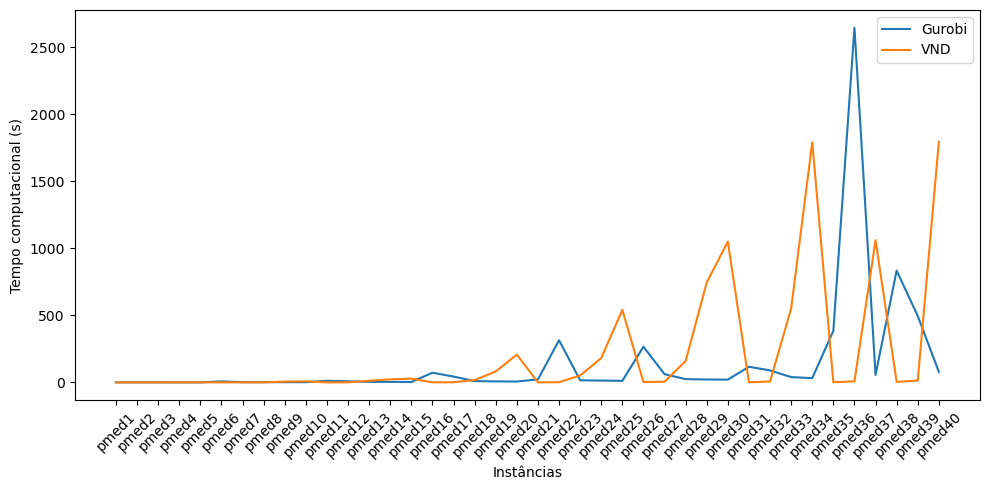

In [16]:
instances = [f"pmed{i}" for i in range(1, 41)]

plt.figure(figsize=(10, 5))
plt.plot(instances, gurobi, label='Gurobi')
plt.plot(instances, vnd, label='VND')

# Escala logarítmica
# plt.yscale("log")

plt.xlabel("Instâncias")
plt.ylabel("Tempo computacional (s)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# plt.savefig("grafico_sem_capacidade.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
# Salva os dados de solucao em um arquivo txt
output_file = 'dados_solucoes_novas1.txt'
with open(output_file, 'w') as file:
    for solucao in solucoes:
        file.write(f"{solucao}\n")

print(f"Soluções foram salvas em {output_file}.")

### Abrindo arquivos com os dados

In [ ]:
solutions = []
solucoes = []

with open("dados_solutions.txt", "r") as file:
    for line in file:
        if line.strip():  # ignora linhas em branco
            solutions.append(ast.literal_eval(line.strip()))

with open("dados_solucoes_novas.txt", "r") as file:
    for line in file:
        if line.strip():  # ignora linhas em branco
            solucoes.append(ast.literal_eval(line.strip()))

In [ ]:
for i, solution in enumerate(solutions):
    for j, solucao in enumerate(solucoes):
        if i == j:
            print(f"gap da instância pmed{i+1}: {(solucao['Custo'] - solution['Dual Bound']) / solution['Dual Bound']}")

In [ ]:
for i, solution in enumerate(solutions):
    for j, solucao in enumerate(solucoes):
        if i == j:
            print(f"gap e tempo pmed{j+1}: {(100 * (solucao['Custo'] - solution['Dual Bound']) / solution['Dual Bound']):.2f}, {solucao['Execution Time']:.2f}")